Hier noch einmal das Notebook, mit dem ihr Wetterdaten der Website https://mesonet.agron.iastate.edu/request/download.phtml?network=DJ__ASOS auswerten könnt (wenn ihr eine Wetterstation auswählt und dann "alle Daten downloaden" nehmt)
<br>
Die Aufgaben sind nochmal angepasst an das, was wir heute vormittag gemacht haben - konkret geht es darum, erstmal die monatlichen Durchschnittstemperaturen an einem Ort anzuschauen, den wärmsten und kältesten Monat zu bestimmen und das einmal graphisch anzuschauen. Danach wollen wir das mit einem (oder mehreren) anderen vergleichen. <br><br><br> Anmerkungen und Fragen und Hinweise gerne an anja.tiede@yfu-deutschland.de

Zelle ausführen: _SHIFT + ENTER_
<br>
Neue Zelle einfügen: _Esc_ (dann ist ein blauer Rand um die Zelle), dann _a_ (above) oder _b_ (below)

In [92]:
# import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from pathlib import Path
#import os

Funktionen

In [161]:
def find_time (row):
    return row["valid"].split(" ")[-1]

def find_day (row):
    return int(row["valid"].split("-")[2].split(" ")[0])

def find_month (row):
    return int(row["valid"].split("-")[1])

def find_year (row):
    return int(row["valid"].split("-")[0])

def initialize_dataset_from_location(original_dataset):
    """
    Get the raw data and adjust is to our purposes.
    
    original_dataset: pandas table
        downloaded from IOWA state university website
    """
    
    # copy the dataset to a new one
    modified_dataset = original_dataset
    
    # delete unnecessary columns
    del modified_dataset["ice_accretion_1hr"]
    del modified_dataset["ice_accretion_3hr"]
    del modified_dataset["ice_accretion_6hr"]
    
    del modified_dataset["peak_wind_gust"]
    del modified_dataset["peak_wind_drct"]
    del modified_dataset["peak_wind_time"] 
    
    del modified_dataset["skyl1"]
    del modified_dataset["skyl2"]
    del modified_dataset["skyl3"]
    del modified_dataset["skyl4"]
    
    del modified_dataset["skyc1"]
    del modified_dataset["skyc2"]
    del modified_dataset["skyc3"]
    del modified_dataset["skyc4"]
    del modified_dataset["wxcodes"]
    del modified_dataset["gust"]
    del modified_dataset["metar"]
    del modified_dataset["mslp"]
    del modified_dataset["elevation"]
    
    
    # append colums for easier filtering by day, month, year, time
    modified_dataset["time"] = original_dataset.apply (lambda row: find_time(row), axis=1)
    modified_dataset["date"] = original_dataset.apply (lambda row: find_day(row), axis=1)
    modified_dataset["month"] = original_dataset.apply (lambda row: find_month(row), axis=1)
    modified_dataset["year"] = original_dataset.apply (lambda row: find_year(row), axis=1)
    
    # delete the rows where there are invalid entries in the temperature range
    modified_dataset = modified_dataset.drop(modified_dataset[modified_dataset["tmpf"] == "M"].index)
    
    return modified_dataset

def daily_avg_tmpc(temp_dataset):
    calc_daily = []


    last_day = temp_dataset.iloc[0]["date"]
    last_month = temp_dataset.iloc[0]["month"]
    last_year = temp_dataset.iloc[0]["year"]

    daily_avg = np.asarray([np.asarray([last_day, last_month, last_year, 0.0])])
    count = 0

    for index, entry in temp_dataset.iterrows():
        #print(entry)
        if entry["date"] == last_day and entry["month"] == last_month and entry["year"] == last_year:
            calc_daily.append(entry["tmpc"])
        else:
            try:
                daily_avg[count,3] = (sum(calc_daily) / len(calc_daily))
            except ZeroDivisionError:
                print(str(entry["date"]) + " " + str(entry["month"]) + " " + str(entry["year"]) + " has zero devision.")
                pass
            last_day = entry["date"]
            last_month = entry["month"]
            last_year = entry["year"]
            count += 1
            daily_avg = np.vstack([daily_avg, np.asarray([last_day, last_month, last_year, 0])])
            calc_daily = []
            
    # do for the last day entry
    try:
        daily_avg[count,2] = (sum(calc_daily) / len(calc_daily))
        #print(str(sum(calc_monthly)) + " " + str(len(calc_monthly)) + " " + str(sum(calc_monthly) / len(calc_monthly)))
    except ZeroDivisionError:
        print(str(entry["date"]) + " " + str(entry["month"]) + " " + str(entry["year"]) + " has zero devision.")
    df = pd.DataFrame(daily_avg, columns = ['date','month','year', 'tmpc'])

    return df

def monthly_avg_tmpc(temp_dataset):
    calc_monthly = []

    last_index = temp_dataset.shape[0] - 2
    last_month = temp_dataset.iloc[0]["month"]
    last_year = temp_dataset.iloc[0]["year"]

    monthly_avg = np.asarray([np.asarray([last_month, last_year, 0.0])])
    count = 0

    for index, entry in temp_dataset.iterrows():
        #print(entry)
        if entry["month"] == last_month and entry["year"] == last_year:
            calc_monthly.append(entry["tmpc"])
        else:
            try:
                monthly_avg[count,2] = (sum(calc_monthly) / len(calc_monthly))
                #print(str(sum(calc_monthly)) + " " + str(len(calc_monthly)) + " " + str(sum(calc_monthly) / len(calc_monthly)))
            except ZeroDivisionError:
                print(str(entry["month"]) + " " + str(entry["year"]) + " has zero devision.")
                pass
            if index == last_index:
                continue
            last_month = entry["month"]
            last_year = entry["year"]
            count += 1
            monthly_avg = np.vstack([monthly_avg, np.asarray([last_month, last_year, 0])])
            calc_monthly = []
    # do for the last month entry
    try:
        monthly_avg[count,2] = (sum(calc_monthly) / len(calc_monthly))
        #print(str(sum(calc_monthly)) + " " + str(len(calc_monthly)) + " " + str(sum(calc_monthly) / len(calc_monthly)))
    except ZeroDivisionError:
        print(str(entry["month"]) + " " + str(entry["year"]) + " has zero devision.")
    df = pd.DataFrame(monthly_avg, columns = ['month','year', 'tmpc'])

    return df

Einlesen und "Brauchbarmachen" der Rohdaten

https://mesonet.agron.iastate.edu/request/download.phtml?network=FR__ASOS
<br>
Select what you want - download all available data

In [142]:
# path to dataset 
path_to_table = "Westerland.txt"

In [143]:
raw_data_westerland = pd.read_csv(path_to_table, low_memory = False)

In [144]:
data_westerland = initialize_dataset_from_location(raw_data_westerland)

In [145]:
# take a look at your dataset

#station: three or four character site identifier
#valid: timestamp of the observation
#tmpf: Air Temperature in Fahrenheit, typically @ 2 meters
#dwpf: Dew Point Temperature in Fahrenheit, typically @ 2 meters
#relh: Relative Humidity in %
#drct: Wind Direction in degrees from *true* north
#sknt: Wind Speed in knots
#alti: Pressure altimeter in inches
#vsby: Visibility in miles
#feel: Apparent Temperature (Wind Chill or Heat Index) in Fahrenheit

data_westerland

,station,valid,lon,lat,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,feel,time,date,month,year
0,EDXW,2011-05-09 00:20,8.3405,54.9132,51.8,48.2,87.47,100.0,14.0,M,30.24,7.00,51.80,00:20,9,5,2011
1,EDXW,2011-05-09 00:50,8.3405,54.9132,51.8,48.2,87.47,100.0,16.0,M,30.24,7.00,51.80,00:50,9,5,2011
2,EDXW,2011-05-09 01:20,8.3405,54.9132,51.8,48.2,87.47,100.0,15.0,M,30.24,7.00,51.80,01:20,9,5,2011
3,EDXW,2011-05-09 01:50,8.3405,54.9132,51.8,48.2,87.47,100.0,14.0,M,30.24,7.00,51.80,01:50,9,5,2011
4,EDXW,2011-05-09 02:20,8.3405,54.9132,51.8,48.2,87.47,100.0,13.0,M,30.24,7.00,51.80,02:20,9,5,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109723,EDXW,2021-05-08 21:50,8.3405,54.9132,46.4,44.6,93.40,150.0,22.0,0.0,29.68,3.11,37.86,21:50,8,5,2021
109724,EDXW,2021-05-08 22:20,8.3405,54.9132,46.4,44.6,93.40,160.0,19.0,0.0,29.68,2.80,38.48,22:20,8,5,2021
109725,EDXW,2021-05-08 22:50,8.3405,54.9132,46.4,46.4,100.00,160.0,20.0,0.0,29.65,2.80,38.26,22:50,8,5,2021
109726,EDXW,2021-05-08 23:20,8.3405,54.9132,48.2,46.4,93.45,170.0,18.0,0.0,29.65,2.36,41.07,23:20,8,5,2021


Temperaturen in °C angeben 

In [146]:
## you need to convert the column to "float" data value
data_westerland["tmpc"] = (data_westerland["tmpf"].astype("float") - 32) * 5/9

Jetzt erstellen wir ein neuen Datensatz, in dem nur Tag, Monat, Jahr und durchscnittliche Tagestemperatur in Celsius angegeben sind. Das gleiche für die Monate.

In [157]:
daily_avg_westerland = daily_avg_tmpc(data_westerland)
montly_avg_westerland = monthly_avg_tmpc(data_westerland)
print("done")

26 12 2015 has zero devision.
done


In [158]:
# Jetzt schauen wir den neuen Datensatz an
montly_avg_westerland

,month,year,tmpc
0,5.0,2011.0,12.638889
1,6.0,2011.0,15.145556
2,7.0,2011.0,15.756098
3,8.0,2011.0,16.226931
4,9.0,2011.0,14.897049
...,...,...,...
116,1.0,2021.0,2.143485
117,2.0,2021.0,1.086516
118,3.0,2021.0,4.535427
119,4.0,2021.0,6.351524


In [162]:
# Was war der wärmste Monat?
# Kannst du nachvollziehen, was hier passiert?
print("Find maximum value")
print(montly_avg_westerland.max())
print("\nFind the maximum index")
print(montly_avg_westerland.idxmax())
print("\nVersion 1")
print(montly_avg_westerland.iloc[38])
print("\nVersion 2")
print(montly_avg_westerland.iloc[montly_avg_westerland.idxmax()[2]])

Find maximum value
month      12.000000
year     2021.000000
tmpc       21.705548
dtype: float64

Find the maximum index
month      7
year     116
tmpc      38
dtype: int64

Version 1
month       7.000000
year     2014.000000
tmpc       21.705548
Name: 38, dtype: float64

Version 2
month       7.000000
year     2014.000000
tmpc       21.705548
Name: 38, dtype: float64


Der wärmste Monat in Westerland war also **Juli 2014** mit **27.7°C** Durchschnittstemperatur.

In [123]:
# Jetzt du - kannst du es für den kältesten Monat herausfinden?
# Was war der kälteste Monat? (Spoiler: Februar 2021)

Jetzt wollen wir uns noch den Temperaturverlauf der letzten Jahre ausgeben lassen.

Text(0.5, 1.0, 'Entwicklung monatliche Durchschnittstemperaturen in Westerland')

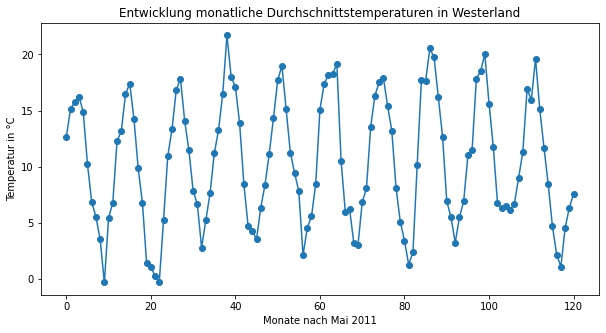

In [159]:
plt.figure(figsize = [10,5])
plt.plot("tmpc", data = montly_avg_westerland, marker = "o")

# hier fehlen aber noch achsenbeschriftungen!
plt.ylabel("Temperatur in °C")
plt.xlabel("Monate nach Mai 2011")
plt.title("Entwicklung monatliche Durchschnittstemperaturen in Westerland")

In [ ]:
# Kannst du die Temperaturen in Westerland vergleichen mit einem anderen Ort deiner Wahl?
# (Falls du dich nicht entscheiden kannst, nimm z.B. Ann Arbour oder Georgetown)